# Projet SD-WAN-ReinforcementLearning

# Partie: Recherche opérationnelle

In [ ]:
#!pip install pulp

Imports

In [1]:
import networkx as nx
import pulp
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

np.random.seed(1)

### Generation of random graph

In [2]:
def image_nertworkx(nodes = 25, edges = 4):
    g = nx.to_directed(nx.fast_gnp_random_graph(nodes,edges/nodes,directed=True))

    check_list = []
    for i, j in g.edges:
        if i not in check_list:
            check_list.append(i)
    for ii in range(nodes):
        if ii not in check_list:
            g = image_nertworkx(nodes , edges)
    return g

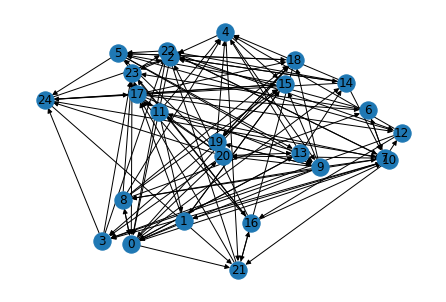

In [3]:
g = image_nertworkx()

node_pose = {}
for i in g.nodes():
    node_pose[i] = (random.uniform(1.0, 10.0),random.uniform(1.0, 10.0))

nx.draw(g,pos = node_pose, with_labels=True)
#plt.savefig("images/original.jpg")
plt.show()

### Generation of random attributes for the graph edges

In [4]:
color = {}
for i, j in g.edges:
    color[i, j] = color[j, i] = (0,0,0,0.5)
    
nx.set_edge_attributes(g, color, 'color')

In [5]:
dict_capa = {}
for i, j in g.edges:
    dict_capa[i, j] = dict_capa[j, i] = round(random.uniform(50.0, 200.0), 0)

nx.set_edge_attributes(g, dict_capa, 'capacity')

In [6]:
dict_used = {}
for i, j in g.edges:
    dict_used[i, j] = dict_used[j, i] = dict_capa[i, j]-round(random.uniform(40.0, dict_capa[i, j]), 0)
    
nx.set_edge_attributes(g, dict_used, 'used')

In [7]:
# instantiate
list_keys = ['shortest_path','min_banwidth_sum']
nodes_models = {}

dict_res = defaultdict(dict)

In [8]:
source = 0
target = 24

In [9]:
Used_df = pd.DataFrame(np.zeros((1,1)))
for link in g.edges:
    s_link = str(link).strip('(').strip(')').replace(',','_').replace(' ','')
    Used_df[s_link] = g.edges[link]['used']
Used_df

,0,0_8,0_10,0_13,0_14,0_20,0_21,1_0,1_15,1_17,...,22_5,22_7,22_12,23_0,23_22,24_2,24_7,24_15,24_17,24_21
0,0.0,15.0,7.0,6.0,69.0,21.0,13.0,9.0,27.0,92.0,...,3.0,51.0,99.0,43.0,19.0,62.0,39.0,15.0,77.0,23.0


In [10]:
Capa_df = pd.DataFrame(np.zeros((1,1)))
for link in g.edges:
    s_link = str(link).strip('(').strip(')').replace(',','_').replace(' ','')
    Capa_df[s_link] = g.edges[link]['capacity']
Capa_df

,0,0_8,0_10,0_13,0_14,0_20,0_21,1_0,1_15,1_17,...,22_5,22_7,22_12,23_0,23_22,24_2,24_7,24_15,24_17,24_21
0,0.0,67.0,97.0,106.0,186.0,66.0,90.0,52.0,158.0,199.0,...,149.0,183.0,145.0,176.0,63.0,109.0,200.0,95.0,120.0,140.0


In [11]:
def new_iter_used(Used_df,action_taken, bdw):
    New_iter = pd.DataFrame(np.zeros((1,1)))
    iter = Used_df.iloc[-1,0]+1
    for link in g.edges:
        s_link = str(link).strip('(').strip(')').replace(',','_').replace(' ','')
        action_taken = str(action_taken).strip('(').strip(')').replace(',','_').replace(' ','')
        if action_taken != s_link:
            random_value = np.random.randint(-2000,2000)/100
        else:
            random_value = bdw
            
        new_value = Used_df.iloc[-1,Used_df.columns.get_loc(s_link)] + random_value
        
        if new_value < 0 :
            new_value = 0
        elif new_value > g.edges[link]['capacity'] :
            new_value = g.edges[link]['capacity']

        New_iter[s_link] = new_value
    print(New_iter.head())
    New_iter.iloc[-1,0] = iter
    Used_df = Used_df.append(New_iter)
    return Used_df


In [12]:
def update_list_df(Used_df):
    list_used_df = []

    for i in range(50):
        df = pd.DataFrame()
        for j in Used_df.keys():
            if str(j).split('_')[0] == str(i):
                if len(str(j).split('_')) == 2:
                    df[str(j).split('_')[1]] = Used_df.iloc[:,Used_df.columns.get_loc(j)]
                
        df['Time'] = Used_df.iloc[:,0]
        list_used_df.append(df)
    return list_used_df

In [13]:
list_used_df = update_list_df(Used_df)
print(list_used_df[1])

     0    15    17  Time
0  9.0  27.0  92.0   0.0


In [14]:
## MARL Part

In [15]:
Used_df = new_iter_used(Used_df,"0_23", 200)
Used_df

     0   0_8  0_10  0_13   0_14   0_20  0_21    1_0   1_15    1_17  ...  22_5  \
0  0.0  5.61     0  25.8  59.96  39.39  2.05  16.63  44.17  100.95  ...  9.43   

    22_7  22_12   23_0  23_22  24_2   24_7  24_15  24_17  24_21  
0  63.38  85.48  36.12   33.9  80.5  52.51  11.79  84.99  34.59  

[1 rows x 110 columns]


,0,0_8,0_10,0_13,0_14,0_20,0_21,1_0,1_15,1_17,...,22_5,22_7,22_12,23_0,23_22,24_2,24_7,24_15,24_17,24_21
0,0.0,15.00,7.0,6.0,69.00,21.00,13.00,9.00,27.00,92.00,...,3.00,51.00,99.00,43.00,19.0,62.0,39.00,15.00,77.00,23.00
0,1.0,5.61,0.0,25.8,59.96,39.39,2.05,16.63,44.17,100.95,...,9.43,63.38,85.48,36.12,33.9,80.5,52.51,11.79,84.99,34.59


In [16]:
def init_colors():
    color = {}
    for i, j in g.edges:
        color[i, j] = color[j, i] = (0,0,0,0.5)

    nx.set_edge_attributes(g, color, 'color')

In [17]:
def get_path_as_list_tuples(path):
    solve_var = [] 
    for i in path.split("_"):
        var = str(i).split('(')
        var = var[1].split(',')
        var[0] = int(var[0])
        var[1] = int(var[1].strip(')'))
        solve_var.append(tuple(var))
    return solve_var

In [18]:
def plot_graph(attributes):
    x = []
    y = []
    for i in range(iter_):
        x.append(dict_res[i][attributes])
        y.append(i)

    p = plt.plot(y, x)

    plt.show(p)
    plt.close()

In [19]:
def draw_path(solve_var):
        for link in g.edges:
            if link in solve_var:
                g.edges[link[0],link[1]]['color'] = (1,0,0,1) 
    
        colors = nx.get_edge_attributes(g,'color').values()

        nx.draw(g, pos = node_pose, 
            edge_color=colors, 
            with_labels=True)
        ## Save chosen path ##
        plt.show()
        #plt.savefig("imgs/Q_table/Q_table_iter_{}".format(iter))
        plt.close()
        init_colors()

In [20]:
def get_possible_actions(current_node):
    sub_list = []
    for (i,j) in g.edges:
        if i == current_node:
            sub_list.append((i,j))
    return sub_list

In [21]:
def get_list_possibles_nodes(current_node):
    sub_list = get_possible_actions(current_node)
    nodes_list = []
    for (i,j) in sub_list:
        nodes_list.append(j)
    #print(nodes_list)
    return nodes_list

In [22]:
def get_state(solve_var,add_dim = True):
    state = np.zeros((net.nodes,net.nodes), np.int8)
    for (i,j) in g.edges:
        if (i,j) in solve_var:
            state[i,j] = 1
        elif i == source:
            state[i,j] = 2
        elif j == target:
            state[i,j] = 2
        else:
            state[i,j] = 0
        if add_dim:
            state = np.expand_dims(state, axis=0)
        state = np.expand_dims(state, axis=0)
        state = np.expand_dims(state, axis=0)
        #print(state.shape)
        return state

In [23]:
def scale(X, x_min, x_max):
    nom = (X-X.min(axis=0))*(x_max-x_min)
    denom = X.max(axis=0) - X.min(axis=0)
    denom[denom==0] = 1
    return x_min + nom/denom 

In [24]:
def get_epsilon():
    return (1.03 - iter_actuel / iter_ ) 

In [25]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense,Dropout, LSTM
from tensorflow.keras.optimizers import Adam

from math import floor

/home/g13/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/g13/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/g13/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/g13/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarnin

In [26]:
dict_model = defaultdict(dict)
for i in g.nodes:
    cpt_output = 0
    
    #print("\n   Node : {}".format(i))
    
    for ii,j in g.edges:
        if (i == ii):
            #print("Edges Output : {}".format(j))
            dict_model[i][j] = g.edges[i, j]['used']
            cpt_output = cpt_output + 1
            
    dict_model[i]["cpt_output"] = cpt_output

In [27]:
def new_iter_used(Used_df,action_taken, bdw):
    New_iter = pd.DataFrame(np.zeros((1,1)))
    iter = Used_df.iloc[-1,0]+1
    for link in g.edges:
        s_link = str(link).strip('(').strip(')').replace(',','_').replace(' ','')
        action_taken = str(action_taken).strip('(').strip(')').replace(',','_').replace(' ','')
        if action_taken != s_link:
            random_value = np.random.randint(-2000,2000)/100
            
        else:
            random_value = bdw
            
        new_value = Used_df.iloc[-1,Used_df.columns.get_loc(s_link)] + random_value
        
        if new_value < 0 :
            new_value = 0
        elif new_value > g.edges[link]['capacity'] :
            new_value = g.edges[link]['capacity']

        New_iter[s_link] = new_value
    New_iter.iloc[-1,0] = iter
    Used_df = Used_df.append(New_iter)
    return Used_df

In [28]:
def _build_compile_model(nodes_models,node):
    Used_df = pd.DataFrame(np.zeros((1,1)))
    for link in g.edges:
        s_link = str(link).strip('(').strip(')').replace(',','_').replace(' ','')
        Used_df[s_link] = g.edges[link]['used']
    #Used_df= new_iter_Used(Used_df,-1, 0)

    list_model = update_list_df(Used_df)
    inputs = list_model[node]

    inputs = np.array(inputs).reshape(1, inputs.shape[1])

    model = Sequential()

    model.add(LSTM(50, return_sequences = True, input_shape = (inputs.shape[0],inputs.shape[1]+1)))
    model.add(Dropout(0.1))
    model.add(LSTM(25, return_sequences = True))
    model.add(Dropout(0.1))

    model.add(Dense(10,activation='relu'))
    model.add(Dense(inputs.shape[1]-1,activation='relu'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    nodes_models[node] = model
    return nodes_models
nodes_models = {}  
for i in range (25):
    nodes_models = _build_compile_model(nodes_models,i)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [60]:
Used_df = pd.DataFrame(np.zeros((1,1)))
for link in g.edges:
    s_link = get_tuple_to_name(link)
    Used_df[s_link] = g.edges[link]['used']

list_model = update_list_df(Used_df)
inputs = list_model[-1]
inputs = np.array(inputs).reshape(1, inputs.shape[1])

inputs = np.append(inputs[0],5)
inputs = np.array(inputs).reshape(1,1, inputs.shape[0])

model = nodes_models[0]
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 50)             11800     
_________________________________________________________________
dropout (Dropout)            (None, 1, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 25)             7600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 25)             0         
_________________________________________________________________
dense (Dense)                (None, 1, 10)             260       
_________________________________________________________________
dense_1 (Dense)              (None, 1, 6)              66        
Total params: 19,726
Trainable params: 19,726
Non-trainable params: 0
____________________________________________________

In [58]:
print(nodes_models)

{0: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fe7e02538d0>, 1: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fe7e02545c0>, 2: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fe7e0246d30>, 3: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fe7de288128>, 4: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fe7dda27ef0>, 5: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fe7dd1f90b8>, 6: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fe7dc9a45f8>, 7: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fe7e029b208>, 8: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fe7d797f208>, 9: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fe7d70d05c0>, 10: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fe7d68f6a20>, 11: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fe7

In [59]:
model.predict(inputs)

array([[[0.        , 0.        , 0.02976669, 0.03606822, 0.0037863 ,
         0.        ]]], dtype=float32)

In [44]:
def get_action(current_node):
    list_model = update_list_df(Used_df)
    
    inputs = list_model[current_node].iloc[-1,:]
    inputs = np.append(inputs,target)
   
    inputs = np.array(inputs)
    inputs = inputs.reshape(1,1, inputs.shape[0])
    expirience_replay[cpt] = inputs
 
    
    sub_list = get_possible_actions(current_node)
    #print("Possible actions from {} are {} ".format(current_node,sub_list))
    if np.random.rand() <= get_epsilon(): #Epsilon
        return random.choice(sub_list)[1]
    else :
        return get_model_action(current_node,inputs)

In [45]:
def get_model_action(current_node,inputs):
    
    local_model = nodes_models[current_node]
    list_of_output = []
    for i in dict_model[current_node].keys():
        if i != 'cpt_output':
            list_of_output.append(i)

    pedicted_values = local_model.predict(inputs)
    #print(pedicted_values)
    
    value = np.argmax(pedicted_values[0])
    
    return list_of_output[value]


In [46]:
def get_indx_from_value(current_node,value):
    list_values = []
    for i,j in g.edges:
        if (current_node == i):
            list_values.append(j)
            
    return list_values.index(value)

In [65]:
def give_final_reward(solve_var,neg_reward):
    for i in range(len(solve_var)) :
      
        action_taken = solve_var[i][1]
        current_node = solve_var[i][0]
      
        local_model = nodes_models[current_node]
        
        state = expirience_replay[i]
        target_model = local_model.predict(state)
      
        action_taken_id = get_indx_from_value(current_node,action_taken)

        if len(solve_var) != max_move:
            target_model[0,0,action_taken_id] = target_model[0,0,action_taken_id] + i/neg_reward
         
        else:
            target_model[0,0,action_taken_id] = target_model[0,0,action_taken_id] - 1
        
        local_model.fit(state,scale(target_model,0,1),epochs=1,verbose=0)
        nodes_models[current_node] = local_model
            

In [48]:
def get_tuple_to_name(path):
    return(str(path).strip('(').strip(')').replace(',','_').replace(' ',''))


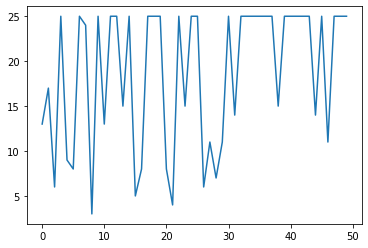

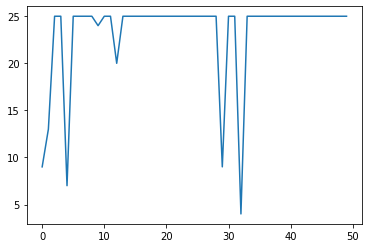

In [66]:
for iii in range(2):
    source = np.random.randint(0,25)
    target = np.random.randint(0,25)
    if source != target :
        iter_ = 50
        iter_actuel = 0
        current_iter = 0
        var_dict = {}
        max_move = 25
        cpt = 0
        bdw = 20

        expirience_replay = {}
        
        summ = 0
        for ii in range(iter_):
            iter_actuel = ii + 1
            current_node = source
            path = ""
            cpt = 0
            solve_var = []
            j = source

            Used_df = pd.DataFrame(np.zeros((1,1)))
            for link in g.edges:
                s_link = get_tuple_to_name(link)
                Used_df[s_link] = g.edges[link]['used']

            flag_finished = False
            while flag_finished != True and cpt < max_move:
                j = get_action (current_node)
                i = current_node
                #print("current node : {}".format(i))
                #print("action taken : {}".format(j))
                if ((i,j) in get_possible_actions(i)):
                    #print("action taken")
                    #Used_df = new_iter_used(Used_df,j,bdw)
                    path += "{}_".format(str((i,j)))
                    solve_var.append((i,j))
                    var_dict[i,j] = 1
                    cpt = cpt + 1
                    #print(Used_df.head())
                    if g.edges[i,j]['capacity'] > Used_df.iloc[-1,Used_df.columns.get_loc(get_tuple_to_name((i,j)))] + bdw:
                        #print("fail")
                        Used_df = new_iter_used(Used_df,j,bdw)
                        current_node = j
                        if j == target:
                            flag_finished = True
                    else:
                        Used_df = new_iter_used(Used_df,j,0)
            path_ = path[:-1]
            solve_var = get_path_as_list_tuples(path_)

            #sum_delay = 0
            #cpt_solve_var = 0
            #for link in solve_var:
            #    s_link = str(link).strip('(').strip(')').replace(',','_').replace(' ','')
            #    sum_delay = sum_delay + Used_df.iloc[cpt_solve_var,Used_df.columns.get_loc(s_link)]
            #    cpt_solve_var = cpt_solve_var +1

            ## Draw chosen path red ##
            #draw_path(solve_var)
            dict_res[ii]['nodes'] = len(solve_var)
            dict_res[ii]['Sum of delay'] = sum_delay
            give_final_reward(solve_var,len(solve_var))
    plot_graph('nodes')
        

#plot_graph(summ/10)
#print("{} : {}".format(test,summ/10))


In [ ]:
for ii in range(iter_):
    print(dict_res[ii]['Sum of delay'] )

In [ ]:
plot_graph('Sum of delay')

In [ ]:
Delay_df

In [ ]:
sum_delay = 0
cpt_solve_var = 0
for link in solve_var:
    s_link = str(link).strip('(').strip(')').replace(',','_').replace(' ','')
    print(s_link)
    sum_delay = sum_delay + Delay_df.iloc[cpt_solve_var,Delay_df.columns.get_loc(s_link)]
    cpt_solve_var = cpt_solve_var +1